# Глубинное обучение, ИИ ВШЭ

## Домашнее задание 2. Классификация при помощи CNN.

### Общая информация

### Оценивание и штрафы

Максимально допустимая оценка за работу без бонусов — 10 баллов. Сдавать задание после указанного срока жесткого дедлайна нельзя.

Сдача работы после мягкого дедлайна штрафуется ступенчато, -1 балл в сутки. Один раз за модуль студентам предоставляется возможность использовать отсрочку и сдать в жесткий дедлайн без штрафа.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

Использование генеративных моделей допустимо на следующих условиях:
- Количество кода, написанное генеративными моделями, не превышает 30%
- Указана модель, использованная для генерации, а также промпт
- В конце работы необходимо описать свой опыт использования генеративного ИИ для решения данного домашнего задания. Укажите как часто Вам приходилось исправлять код своими руками или просить модель что-то исправить. Было ли это быстрее, чем написать код самим?

В случае невыполнения этих требований работа не оценивается и оценка за неё не превышает 0 баллов.

### О задании

В этом задании вам предстоит познакомиться со сверточными сетями и их обучением для классификации изображений с использованием библиотеки PyTorch.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm

## 0. Загрузка данных

Работать мы будем с набором данных [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html). CIFAR10 представляет собой набор изображений 32х32 пикселя, разделенных на 10 классов.

![title](https://pytorch.org/tutorials/_images/cifar10.png)




Набор данных уже определен в <code>torchvision.datasets</code>, так что возьмем его оттуда.



In [2]:
# Для тру нормализации
# mean = [0.4914, 0.4822, 0.4465]
# std = [0.2470, 0.2435, 0.2616]
# Тут взяты значения как в одном из туториалов пайторча :)


def get_cifar10_data(batch_size, transform_train):
    torch.manual_seed(0)
    np.random.seed(0)

    transform_test = transforms.Compose(
        [
            transforms.ToTensor(),
            # Переводим цвета пикселей в отрезок [-1, 1]
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )

    # Загружаем данные
    trainvalset = torchvision.datasets.CIFAR10(
        root="./data", train=True, download=True, transform=transform_train
    )
    testset = torchvision.datasets.CIFAR10(
        root="./data", train=False, download=True, transform=transform_test
    )

    # В датасете определено разбиение только на train и test,
    # так что валидацию дополнительно выделяем из обучающей выборки
    train_idx, valid_idx = train_test_split(
        np.arange(len(trainvalset)), test_size=0.3, shuffle=True, random_state=0
    )
    trainset = torch.utils.data.Subset(trainvalset, train_idx)
    valset = torch.utils.data.Subset(trainvalset, valid_idx)

    train_loader = torch.utils.data.DataLoader(
        trainset, batch_size=batch_size, shuffle=True, num_workers=2
    )
    val_loader = torch.utils.data.DataLoader(
        valset, batch_size=batch_size, shuffle=False, num_workers=2
    )
    test_loader = torch.utils.data.DataLoader(
        testset, batch_size=batch_size, shuffle=False, num_workers=2
    )

    return train_loader, val_loader, test_loader

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(
    batch_size=64, transform_train=transform
)

100%|██████████| 170M/170M [00:16<00:00, 10.5MB/s]


Посмотрим на изображения:

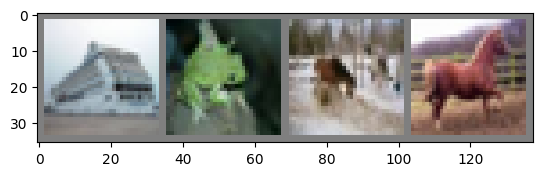

ship frog horse horse


In [4]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))

classes = (
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
)
print(*[classes[labels[i]] for i in range(4)])

## 1. Задание сверточной сети (3 балла)

Теперь нам нужно задать сверточную нейронную сеть, которую мы будем обучать классифицировать изображения.

Используем сеть, основанную на одном блоке архитектуры, похожей на ResNet. Обратите внимание, это не ResNet 1 в 1.

<img src="https://i.ibb.co/2hg962h/basic-block.png" width="500"/>

__Указания:__

- Все сверточные слои должны иметь 32 выходных канала, а также не должны изменять ширину и высоту изображения.
- Выход блока сократите до размерности 32х4х4, применив average pooling.
- Для получения итоговых логитов, распрямите выход пулинга в вектор из 512 элементов, а затем пропустите его через линейный слой.

**Задание 1.1 (3 балла).**

Определите архитектуру сети соответственно схеме и указаниям выше.

Ключевые слова: <code>Conv2d</code>, <code>BatchNorm2d</code>, <code>AvgPool2d</code>.

Архитектура ResNet

In [5]:
n_classes = 10

class BasicBlockNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.BatchNorm2d(32)
        )
        self.short_net = nn.Conv2d(3, 32, 1)
        self.pool = nn.AvgPool2d(8)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(32 * 4 * 4, 10)

    def forward(self, x):
        out = self.net(x)
        out_short = self.short_net(x)
        out = F.relu(out + out_short)
        out = self.pool(out)
        out = self.flatten(out)
        out = self.fc(out)

        return out

In [6]:
net = BasicBlockNet()
net

BasicBlockNet(
  (net): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (short_net): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
  (pool): AvgPool2d(kernel_size=8, stride=8, padding=0)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=512, out_features=10, bias=True)
)

Проверим, что выход сети имеет корректную размерность:

In [7]:
assert net(torch.zeros((10, 3, 32, 32))).shape == (10, 10)

Чтобы проводить вычисления на GPU, в PyTorch необходимо руками перекладывать объекты, с которыми вы хотите проводить вычисления, на графический ускоритель. Это делается следующим образрм:

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [9]:
net = net.to(device)

Подключение GPU в google.colab:

**Среда выполнения** -> **Сменить среду выполнения** -> **Аппаратный ускоритель** -> **GPU**

## 2. Обучение и тестирование модели (3 балла)

**Задание 2.1 (2 балла).** Переходим к обучению модели. Заполните пропуски в функциях <code>test</code> и <code>train_epoch</code>. В качестве функции потерь будем использовать [кросс-энтропию](https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html), а в качестве метрики качества accuracy.

In [10]:
def test(model, loader):
    loss_log = []
    acc_log = []
    model.eval()

    for data, target in loader:
        data, target = data.to(device), target.to(device)
        data = data.float()
        y_pred = model(data)
        loss = F.cross_entropy(y_pred, target)

        loss_log.append(loss.item())

        pred_classes = torch.argmax(y_pred, dim=1)
        acc = (pred_classes == target).sum() / target.size(0)

        acc_log.append(acc.item())

    return np.mean(loss_log), np.mean(acc_log)


def train_epoch(model, optimizer, train_loader):
    loss_log = []
    acc_log = []
    model.train()

    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        data = data.float()
        y_pred = model(data)
        loss = F.cross_entropy(y_pred, target)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        loss_log.append(loss.item())

        pred_classes = torch.argmax(y_pred, dim=1)
        acc = (pred_classes == target).sum() / target.size(0)

        acc_log.append(acc.item())

    return loss_log, acc_log


def train(model, optimizer, n_epochs, train_loader, val_loader, scheduler=None):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []

    for epoch in range(n_epochs):
        train_loss, train_acc = train_epoch(model, optimizer, train_loader)
        val_loss, val_acc = test(model, val_loader)

        train_loss_log.extend(train_loss)
        train_acc_log.extend(train_acc)

        val_loss_log.append(val_loss)
        val_acc_log.append(val_acc)

        print(f"Epoch {epoch}")
        print(f" train loss: {np.mean(train_loss)}, train acc: {np.mean(train_acc)}")
        print(f" val loss: {val_loss}, val acc: {val_acc}\n")

        if scheduler is not None:
            scheduler.step()

    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

Запустим обучение модели. В качестве оптимизатора будем использовать стохастический градиентный спуск, который является де-факто стандартом в задачах компьютерного зрения (наравне с <code>Adam</code>).

__Замечание:__ Для достижения наилучшего качества в нашем случае потребуется обучать модель несколько сотен эпох. Однако в целях экономии вашего времени и сил, во всех экспериментах мы ограничимся 20 эпохами.

In [ ]:
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader
)

Epoch 0
 train loss: 1.463200527200751, train acc: 0.47949448298710573
 val loss: 1.214601350337901, val acc: 0.5683289007937654

Epoch 1
 train loss: 1.157560685108087, train acc: 0.5957128166934472
 val loss: 1.1457291907452523, val acc: 0.6033244680851064

Epoch 2
 train loss: 1.0462632310019986, train acc: 0.6381765801248428
 val loss: 1.0574518330553744, val acc: 0.6298758866939139

Epoch 3
 train loss: 0.983797746123082, train acc: 0.6590493601462523
 val loss: 1.0882822762144373, val acc: 0.6235150710065314

Epoch 4
 train loss: 0.9531661039950425, train acc: 0.6688593628201668
 val loss: 1.006794697426735, val acc: 0.6518838654173181

Epoch 5
 train loss: 0.9255486504469319, train acc: 0.6788448354661791
 val loss: 0.9780284678682368, val acc: 0.6676418441407224

Epoch 6
 train loss: 0.8961629570075319, train acc: 0.690429942590445
 val loss: 1.0531199143287984, val acc: 0.64663120584285

Epoch 7
 train loss: 0.881816792095819, train acc: 0.6915235701383141
 val loss: 0.9224938

Посчитайте точность на тестовой выборке:

In [ ]:
test_loss_log, test_acc_log = test(net, test_loader)
print(f" test loss: {test_loss_log}, test acc: {test_acc_log}\n")

 test loss: 0.8892154701196464, test acc: 0.6942675159235668



Если вы все сделали правильно, у вас должна была получиться точность $\ge 67\%$.

**Задание 2.2 (1 балл).** Постройте графики зависимости функции потерь и точности классификации от номера шага оптимизатора. На каждом графике расположите данные и для обучающей и для валидационной выборки, итого у вас должно получиться два графика. Обратите внимание, что на обучающей выборке эти данные считаются по каждому батчу, на валидационной же они считаются по всей выборке раз в эпоху.

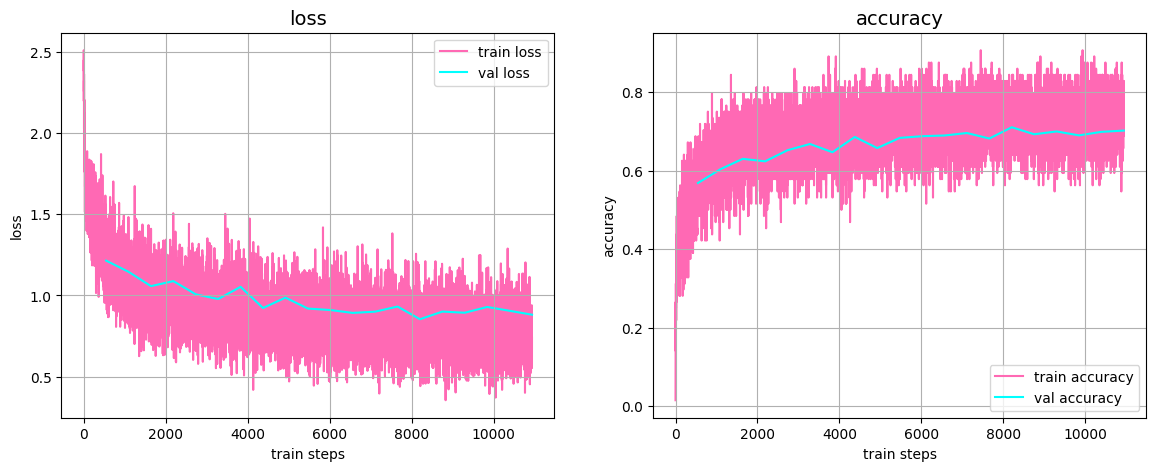

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Loss
axs[0].plot(train_loss_log, c="#FF69B4", label="train loss", zorder=1)
steps = list(
    range(0, len(train_loss_log) + 1, int(len(train_loss_log) / len(val_loss_log)))
)[1:]
axs[0].plot(steps, val_loss_log, c="#00FFFF", label="val loss", zorder=1)
axs[0].set_title("loss", fontsize=14)
axs[0].set_xlabel("train steps")
axs[0].set_ylabel("loss")
axs[0].legend()
axs[0].grid(True)

# Accuracy
axs[1].plot(train_acc_log, c="#FF69B4", label="train accuracy", zorder=1)
steps = list(
    range(0, len(train_acc_log) + 1, int(len(train_acc_log) / len(val_acc_log)))
)[1:]
axs[1].plot(steps, val_acc_log, c="#00FFFF", label="val accuracy", zorder=1)
axs[1].set_title("accuracy", fontsize=14)
axs[1].set_xlabel("train steps")
axs[1].set_ylabel("accuracy")
axs[1].legend()
axs[1].grid(True)
plt.show()

## 3. Расписание длины шага (2 балла)

С курса "Машинное обучение 1" вы уже должны знать, что сходимость стохастического градиентного спуска мы можем теоретически гарантировать только если будем определенным образом со временем уменьшать длину шага. На практике при обучении нейронных сетей такая техника оказывается очень полезной, однако теоретически обоснованными способами уменьшения длины шага фантазия не ограничивается.

Одним из простейших способов является кусочно постоянная функция: на нескольких фиксированных эпохах уменьшаем длину шага в константу раз.

In [ ]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader, scheduler
)

Epoch 0
 train loss: 1.467176029625497, train acc: 0.4781682554503028
 val loss: 1.307462062480602, val acc: 0.5363253547790202

Epoch 1
 train loss: 1.152665197631341, train acc: 0.5975981000572498
 val loss: 1.1350802977034387, val acc: 0.6045434397585848

Epoch 2
 train loss: 1.0567641825954919, train acc: 0.63214530565621
 val loss: 1.2735909784093815, val acc: 0.5656028369639782

Epoch 3
 train loss: 0.996950589542633, train acc: 0.6515286302217835
 val loss: 1.0131596988820015, val acc: 0.6529033688788718

Epoch 4
 train loss: 0.9532524453002749, train acc: 0.6666272199785905
 val loss: 0.9960766566560624, val acc: 0.6524822695458189

Epoch 5
 train loss: 0.9201831654722119, train acc: 0.6810524942016253
 val loss: 0.9449746512352152, val acc: 0.6736037234042553

Epoch 6
 train loss: 0.9011110765297626, train acc: 0.6851495168762626
 val loss: 0.9542483768564589, val acc: 0.6751329787234043

Epoch 7
 train loss: 0.884529922191578, train acc: 0.6923845978062158
 val loss: 0.890695

Посчитайте точность на тестовой выборке:

In [ ]:
ts_loss_log, ts_acc_log = test(net, test_loader)
print(f" test loss: {ts_loss_log}, test acc: {ts_acc_log}\n")

 test loss: 0.8413877528943833, test acc: 0.7123805732484076



**Задание 3.0 (0.5 баллов).** Здесь может возникнуть вопрос: а что будет, если мы не будем уменьшать длину шага в процессе обучения, а сразу возьмем констатную, равную значению нашей кусочно-постоянной функции на последних эпохах, то есть $0.001$ в нашем случае. Запустите обучение и проверьте, что в таком случае мы получим худшее качество на тестовой выборке.

In [ ]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
tr_const_loss_log, tr_const_acc_log, val_const_loss_log, val_const_acc_log = train(
    net, optimizer, 20, train_loader, val_loader
)

Epoch 0
 train loss: 1.8587619345192499, train acc: 0.34669218464351004
 val loss: 1.638534021884837, val acc: 0.431781914893617

Epoch 1
 train loss: 1.5726200045789618, train acc: 0.44763645862094664
 val loss: 1.4885172468550663, val acc: 0.47794769507773377

Epoch 2
 train loss: 1.4449705208023462, train acc: 0.49218137902795067
 val loss: 1.4080905006286946, val acc: 0.5047650710065315

Epoch 3
 train loss: 1.3608066447256253, train acc: 0.5222887830498886
 val loss: 1.3148924822502948, val acc: 0.5404698582405739

Epoch 4
 train loss: 1.299643113364685, train acc: 0.5453977867061957
 val loss: 1.2576500342247334, val acc: 0.5649157801841168

Epoch 5
 train loss: 1.2457128600838852, train acc: 0.5636752416708352
 val loss: 1.2149466225441465, val acc: 0.5780363476022761

Epoch 6
 train loss: 1.2047301500327408, train acc: 0.5813854793307986
 val loss: 1.2027148203646882, val acc: 0.5806959220703612

Epoch 7
 train loss: 1.1603742990458905, train acc: 0.5960147885343492
 val loss: 

In [ ]:
ts_const_loss_log, ts_const_acc_log = test(net, test_loader)
print(f" test loss with const lr=0.001: {ts_const_loss_log}, test acc with const lr=0.001: {ts_const_acc_log}\n")

 test loss with const lr=0.001: 0.9374507255614943, test acc with const lr=0.001: 0.6750597133757962



**Задание 3.1 (1.5 балла).** Изучите, какие еще способы уменьшения длины шага представлены в <code>torch.optim.lr_scheduler</code>. Выберите несколько из них, объясните, как они устроены, и обучите модель с ними. Удалось ли добиться улучшения качества на тестовой выборке?

In [ ]:
net1 = BasicBlockNet().to(device)
optimizer1 = optim.SGD(net1.parameters(), lr=0.1, momentum=0.9)
scheduler1 = optim.lr_scheduler.ExponentialLR(optimizer1, gamma=0.9)
tr_loss_log_exp, tr_acc_log_exp, val_loss_log_exp, val_acc_log_exp = train(
    net1, optimizer1, 20, train_loader, val_loader, scheduler1
)

Epoch 0
 train loss: 1.4726643402136221, train acc: 0.47300617001828155
 val loss: 1.3724273798313547, val acc: 0.5336436170212766

Epoch 1
 train loss: 1.1298639404926265, train acc: 0.6065021873174246
 val loss: 1.026384334868573, val acc: 0.6447695037151905

Epoch 2
 train loss: 1.015347524796369, train acc: 0.6448811700182815
 val loss: 1.0135857424837478, val acc: 0.6526152483960416

Epoch 3
 train loss: 0.9514216924498242, train acc: 0.6686879734234574
 val loss: 0.9863924627608441, val acc: 0.6516843973322117

Epoch 4
 train loss: 0.9097296200025234, train acc: 0.6828765670821697
 val loss: 0.9495926101157006, val acc: 0.6671985816448293

Epoch 5
 train loss: 0.8807418859092148, train acc: 0.6946330634941784
 val loss: 0.9324133862840368, val acc: 0.6787234042553192

Epoch 6
 train loss: 0.8567240924678293, train acc: 0.7031943719609346
 val loss: 0.9052774794558262, val acc: 0.6879210994598713

Epoch 7
 train loss: 0.833518091023949, train acc: 0.7116414208298846
 val loss: 0.8

In [ ]:
ts_loss_log_exp, ts_acc_log_exp = test(net1, test_loader)
print(f" test loss with ExponentialLR sheduler: {ts_loss_log_exp}, test acc with ExponentialLR sheduler: {ts_acc_log_exp}\n")

 test loss with ExponentialLR sheduler: 0.8363032365680501, test acc with ExponentialLR sheduler: 0.7128781847133758



In [ ]:
net2 = BasicBlockNet().to(device)
optimizer2 = optim.SGD(net2.parameters(), lr=0.1, momentum=0.9)
scheduler2 = optim.lr_scheduler.StepLR(optimizer2, step_size = 5,  gamma=0.1)
tr_loss_log_steplr, tr_acc_log_steplr, val_loss_log_steplr, val_acc_log_steplr = train(
    net2, optimizer2, 20, train_loader, val_loader, scheduler2
)

Epoch 0
 train loss: 1.5042578419993957, train acc: 0.4614129016342721
 val loss: 1.3178876602903324, val acc: 0.5375443263256804

Epoch 1
 train loss: 1.2219065354772634, train acc: 0.5718488835983346
 val loss: 1.1133983563869558, val acc: 0.6091755319148936

Epoch 2
 train loss: 1.1049102470687364, train acc: 0.6164631758573068
 val loss: 1.0642776796158324, val acc: 0.626817376055616

Epoch 3
 train loss: 1.0355053188813887, train acc: 0.6412697506343207
 val loss: 1.0874572419105693, val acc: 0.6236702127659575

Epoch 4
 train loss: 0.989995601299258, train acc: 0.6560663685502256
 val loss: 0.9754504274814687, val acc: 0.6609485816448293

Epoch 5
 train loss: 0.8528154489109242, train acc: 0.7061120723893481
 val loss: 0.8965166469837756, val acc: 0.6890957446808511

Epoch 6
 train loss: 0.8291865264148991, train acc: 0.715065128079716
 val loss: 0.887028697703747, val acc: 0.6939494680851064

Epoch 7
 train loss: 0.8207856288121866, train acc: 0.717970586346098
 val loss: 0.8754

In [ ]:
ts_loss_log_steplr, ts_acc_log_steplr = test(net2, test_loader)
print(f" test loss with StepLR sheduler: {ts_loss_log_steplr}, test acc with StepLR sheduler: {ts_acc_log_steplr}\n")

 test loss with StepLR sheduler: 0.8741496364781811, test acc with StepLR sheduler: 0.6987460191082803



In [ ]:
net3 = BasicBlockNet().to(device)
optimizer3 = optim.SGD(net3.parameters(), lr=0.1, momentum=0.9)
scheduler3 = optim.lr_scheduler.CosineAnnealingLR(optimizer3, T_max=20)
tr_loss_log_cos, tr_acc_log_cos, val_loss_log_cos, val_acc_log_cos = train(
    net3, optimizer3, 20, train_loader, val_loader, scheduler3
)

Epoch 0
 train loss: 1.483978698414902, train acc: 0.469039729787837
 val loss: 1.2026086551077821, val acc: 0.5798758866939139

Epoch 1
 train loss: 1.156141869982592, train acc: 0.5942682489834494
 val loss: 1.1006622058279971, val acc: 0.614849290949233

Epoch 2
 train loss: 1.0487604462686362, train acc: 0.6331287542906279
 val loss: 1.1167804228498581, val acc: 0.6181959220703612

Epoch 3
 train loss: 0.9860213321567236, train acc: 0.6592656372887997
 val loss: 1.017120827766175, val acc: 0.6470744680851064

Epoch 4
 train loss: 0.9429702816541278, train acc: 0.6728747715897708
 val loss: 1.0127680291520789, val acc: 0.6559397164811479

Epoch 5
 train loss: 0.90759071800347, train acc: 0.6855698289993258
 val loss: 0.9871614111230729, val acc: 0.6562056739279565

Epoch 6
 train loss: 0.8768232091035442, train acc: 0.6971018870090436
 val loss: 0.9040634495146731, val acc: 0.6922872340425532

Epoch 7
 train loss: 0.8506513576838827, train acc: 0.703382084095064
 val loss: 0.9306471

In [ ]:
ts_loss_log_cos, ts_acc_log_cos = test(net3, test_loader)
print(f" test loss with CosineAnnealingLR sheduler: {ts_loss_log_cos}, test acc with CosineAnnealingLR sheduler: {ts_acc_log_cos}\n")

 test loss with CosineAnnealingLR sheduler: 0.8146374176262291, test acc with CosineAnnealingLR sheduler: 0.7208399681528662



1. [ExponentialLR](https://pytorch.org/docs/main/generated/torch.optim.lr_scheduler.ExponentialLR.html#torch.optim.lr_scheduler.ExponentialLR) умножает lr после каждой эпохи на gamma(0.9)
2. [StepLR](https://pytorch.org/docs/main/generated/torch.optim.lr_scheduler.StepLR.html#torch.optim.lr_scheduler.StepLR) умножает lr после каждых step_size эпох на gamma(0.1)
3. [CosineAnnealingLR](https://pytorch.org/docs/main/generated/torch.optim.lr_scheduler.CosineAnnealingLR.html#torch.optim.lr_scheduler.CosineAnnealingLR) изменяет за все эпохи (T=20) lr по косинусоидальному закону (формула по ссылке)


Метрика незначительно улучшилась при ExponentialLR на 0.05% и практически на 1% при использовании CosineAnnealingLR, при этом при StepLR accuracy ухудшилась на чуть больше 1%.


## 4. Аугментации данных (2 балла)

Еще одной стандартной техникой, применяющейся в глубинном обучении, а особенно часто в компьютерном зрении, являются аугментации данных. Суть аугментаций состоит в том, что мы можем некоторым синтетическим образом видоизменять объекты обучающей выборки, тем самым расширяя ее, а также делая итоговую модель более устойчивой к таким изменениям.

Простейшая аугментация, которую можно применить к картинкам — разворот картинки по горизонтальной оси. То есть при обучении модели с вероятностью $0.5$ мы будем разворачивать картинку из обучающей выборки.

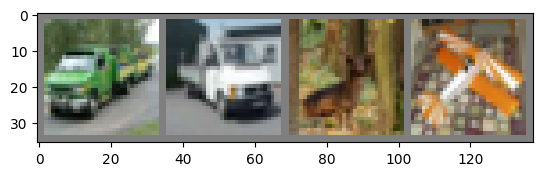

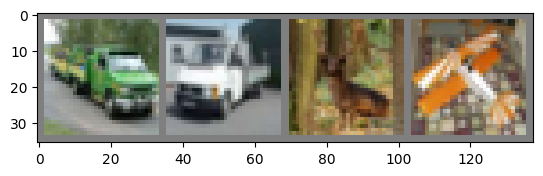

In [11]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))

imshow(torchvision.utils.make_grid(transforms.functional.hflip(images[:4])))

Наиболее удобным способом работы с аугментациями в PyTorch является их задание в списке <code>transforms</code>, который затем передается в загрузчик данных. Обучим нашу сеть, применяя горизонтальные повороты:

In [12]:
transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

train_loader, val_loader, test_loader = get_cifar10_data(
    batch_size=64, transform_train=transform
)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader, scheduler
)

Epoch 0
 train loss: 1.4857028554954739, train acc: 0.4707005746403821
 val loss: 1.2906211716063478, val acc: 0.536812943346957

Epoch 1
 train loss: 1.1852572367439758, train acc: 0.5833564573929558
 val loss: 1.1160549848637682, val acc: 0.6117242909492331

Epoch 2
 train loss: 1.0609604708673313, train acc: 0.6302436994460209
 val loss: 1.076185685269376, val acc: 0.6300753547790202

Epoch 3
 train loss: 1.0004637891893196, train acc: 0.6520305563588465
 val loss: 0.981999830489463, val acc: 0.6591755319148936

Epoch 4
 train loss: 0.9611929611488496, train acc: 0.6682758226691042
 val loss: 1.0237418986381368, val acc: 0.6394281914893617

Epoch 5
 train loss: 0.9233308493328268, train acc: 0.6778409833010197
 val loss: 0.9315125571920516, val acc: 0.6709441489361702

Epoch 6
 train loss: 0.9042664751601176, train acc: 0.6894628166934472
 val loss: 0.9758961786615088, val acc: 0.6628546100981692

Epoch 7
 train loss: 0.8926772209909324, train acc: 0.6889568098720292
 val loss: 0.89

Посчитайте точность на тестовой выборке:

In [14]:
ts_loss_log, ts_acc_log = test(net, test_loader)
print(f" test loss with Augmentation: {ts_loss_log}, test acc with Augmentation: {ts_acc_log}\n")

 test loss with Augmentation: 0.7934320345046414, test acc with Augmentation: 0.7270103503184714



**Задание 4.1 (2 балла).** Изучите, какие еще способы аугментаций изображений представлены в <code>torchvision.transforms</code>. Выберите несколько из них, объясните, как они устроены, и обучите модель с ними (по отдельности и вместе). Удалось ли добиться улучшения качества на тестовой выборке?

1. [RandomRotation](https://pytorch.org/vision/main/generated/torchvision.transforms.v2.RandomRotation.html#torchvision.transforms.v2.RandomRotation) - поворачивает изображение на случайный угол в диапазоне [-degrees, degrees] ([-15, 15])

In [28]:
transform_withRandomRotation = transforms.Compose(
    [
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

train_loader, val_loader, test_loader = get_cifar10_data(
    batch_size=64, transform_train=transform_withRandomRotation
)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader, scheduler
)

Epoch 0
 train loss: 1.5485538231171463, train acc: 0.4444984003656307
 val loss: 1.3444414316339697, val acc: 0.5186835106382979

Epoch 1
 train loss: 1.2798319095013564, train acc: 0.5466546422820641
 val loss: 1.1870687053558675, val acc: 0.5783909574468085

Epoch 2
 train loss: 1.1638129231480838, train acc: 0.5923870463040019
 val loss: 1.1106931615383067, val acc: 0.6101063829787234

Epoch 3
 train loss: 1.097881501291962, train acc: 0.6154103552619543
 val loss: 1.066381629477156, val acc: 0.6260416667512123

Epoch 4
 train loss: 1.0531740069825208, train acc: 0.6293051384484746
 val loss: 1.0496062859575799, val acc: 0.6302748228641266

Epoch 5
 train loss: 1.0240817034048397, train acc: 0.6418736942071583
 val loss: 1.0469916518698348, val acc: 0.6332446808510638

Epoch 6
 train loss: 1.001839646909529, train acc: 0.6495494907909163
 val loss: 0.994576465576253, val acc: 0.6495124114320633

Epoch 7
 train loss: 0.9858680619182273, train acc: 0.654638123577648
 val loss: 0.9922

In [30]:
ts_loss_log, ts_acc_log = test(net, test_loader)
print(f" test loss with RandomRotation: {ts_loss_log}, test acc with RandomRotation: {ts_acc_log}\n")

 test loss with RandomRotation: 0.8284090774454129, test acc with RandomRotation: 0.7151671974522293



Метрика на тесте ухудшилась

2. [RandomCrop](https://pytorch.org/vision/main/generated/torchvision.transforms.v2.RandomCrop.html#torchvision.transforms.v2.RandomCrop) - обрезает изображение в случайном месте. В нашем случае выходной размер обрезки равен 32

In [31]:
transform_withRandomCrop = transforms.Compose(
    [
        transforms.RandomCrop(size=32),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

train_loader, val_loader, test_loader = get_cifar10_data(
    batch_size=64, transform_train=transform_withRandomCrop
)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader, scheduler
)

Epoch 0
 train loss: 1.49331017691213, train acc: 0.4687540807933215
 val loss: 1.2790980359341235, val acc: 0.5419547872340426

Epoch 1
 train loss: 1.1843756282569287, train acc: 0.5839644816501485
 val loss: 1.1001236159750756, val acc: 0.6183953901554676

Epoch 2
 train loss: 1.0579133383534727, train acc: 0.6334552102376599
 val loss: 1.0390891245070923, val acc: 0.6423758866939139

Epoch 3
 train loss: 0.9928548915730534, train acc: 0.6553563267482918
 val loss: 0.9805207201775085, val acc: 0.6602171986661058

Epoch 4
 train loss: 0.949401565509043, train acc: 0.6685084226580381
 val loss: 0.995642712775697, val acc: 0.6526595744680851

Epoch 5
 train loss: 0.9159811403895209, train acc: 0.6825378689731061
 val loss: 0.9771886538951955, val acc: 0.658843085106383

Epoch 6
 train loss: 0.8985159601982159, train acc: 0.6878468595867401
 val loss: 0.9811406072149885, val acc: 0.6584663120990104

Epoch 7
 train loss: 0.8774583727611702, train acc: 0.6953308632430473
 val loss: 0.9223

In [33]:
ts_loss_log, ts_acc_log = test(net, test_loader)
print(f" test loss with RandomCrop: {ts_loss_log}, test acc with RandomCrop: {ts_acc_log}\n")

 test loss with RandomCrop: 0.8175962853963208, test acc with RandomCrop: 0.721437101910828



Метри незначительно ухудшилось, но лучше чем при использовании RandomRotation

3. [ColorJitter](https://pytorch.org/vision/main/generated/torchvision.transforms.v2.ColorJitter.html#torchvision.transforms.v2.ColorJitter) изменяет яркость, контрастность, насыщенность, оттенок и другие свойства изображения, в нашем случае мы изменили: яркость, которая выбирается равномерно из [max(0, 1 - 0.1), 1 + 0.1], контраст, который выбирается равномерно из [max(0, 1 - 0.1), 1 + 0.1] и насыщенность, которая выбирается равномерно из [max(0, 1 - 0.1), 1 + 0.1]

In [26]:
transform_withColorJitter = transforms.Compose(
    [
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

train_loader, val_loader, test_loader = get_cifar10_data(
    batch_size=64, transform_train=transform_withColorJitter
)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader, scheduler
)

Epoch 0
 train loss: 1.4862008151450148, train acc: 0.470349634369287
 val loss: 1.297847780268243, val acc: 0.5318262412192973

Epoch 1
 train loss: 1.1711052828340687, train acc: 0.5907751697726834
 val loss: 1.1012636055337621, val acc: 0.6183289007937655

Epoch 2
 train loss: 1.0521130215315322, train acc: 0.6335898733662078
 val loss: 1.0264998839256612, val acc: 0.6477615249917862

Epoch 3
 train loss: 0.9871140218304106, train acc: 0.6554420214466464
 val loss: 0.9803971627925304, val acc: 0.6640735816448293

Epoch 4
 train loss: 0.9497784332557831, train acc: 0.670010120166939
 val loss: 0.9978859602136815, val acc: 0.6493351063829788

Epoch 5
 train loss: 0.9186488042365917, train acc: 0.680375097983498
 val loss: 1.0064344601428254, val acc: 0.6535239361702128

Epoch 6
 train loss: 0.8977775554116509, train acc: 0.6883283820840951
 val loss: 0.9521542937197583, val acc: 0.6690381207364671

Epoch 7
 train loss: 0.8859041870947948, train acc: 0.69042586190609
 val loss: 0.93937

In [27]:
ts_loss_log, ts_acc_log = test(net, test_loader)
print(f" test loss with ColorJitter: {ts_loss_log}, test acc with ColorJitter: {ts_acc_log}\n")

 test loss with ColorJitter: 0.8202432777471603, test acc with ColorJitter: 0.7191480891719745



Метрика на тесте также ухудшилась и хуже, чем при использовании RandomCrop, но лучше, чем при использовании RandomRotation

In [34]:
transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.RandomCrop(size=32),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

train_loader, val_loader, test_loader = get_cifar10_data(
    batch_size=64, transform_train=transform
)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader, scheduler
)

Epoch 0
 train loss: 1.5607222131227008, train acc: 0.4392669430816413
 val loss: 1.364384071877662, val acc: 0.5090868795171697

Epoch 1
 train loss: 1.30067919442597, train acc: 0.5397990664136911
 val loss: 1.224325277450237, val acc: 0.5675531914893617

Epoch 2
 train loss: 1.191404188463849, train acc: 0.5803653043192527
 val loss: 1.1516045027590813, val acc: 0.5946143617021277

Epoch 3
 train loss: 1.13604070303427, train acc: 0.6030499151681415
 val loss: 1.102457879705632, val acc: 0.6113918441407225

Epoch 4
 train loss: 1.0951663755847505, train acc: 0.6170222316843065
 val loss: 1.1553149172600279, val acc: 0.5996453901554676

Epoch 5
 train loss: 1.064715477840556, train acc: 0.6262854204753199
 val loss: 1.0620872061303321, val acc: 0.6279255319148936

Epoch 6
 train loss: 1.0379155512483726, train acc: 0.6387805236976805
 val loss: 1.072058965804729, val acc: 0.6245567377577437

Epoch 7
 train loss: 1.0271405720405649, train acc: 0.6412534277879341
 val loss: 1.036445710

In [36]:
ts_loss_log, ts_acc_log = test(net, test_loader)
print(f" test loss: {ts_loss_log}, test acc: {ts_acc_log}\n")

 test loss: 0.8371934746481051, test acc: 0.7161624203821656



Улучшить качество не удалось(((

## Бонус. Логирование в wandb (1 балл)

На практике специалиста по глубинному обучению часто встречаются ситуации, когда нейросеть учится на каком-то удаленном сервере. И обычно вам хочется отслеживать прогресс обучения, особенно когда время обучения модели исчисляется днями или неделями. Для таких целей существует несколько инструментов. Вероятно, самый популярный из них — [wandb](https://wandb.ai/site).

Ваша задача состоит в том, чтобы разобраться как им пользоваться, и повторить задания 2.1 и 2.2 с его использованием. Обучение вы можете запускать в этом же ноутбуке, но теперь вам необходимо через wandb логировать значения функции потерь и точности на обучающей выборке и на валидационной. Результатом работы должны быть ваш код и публичная ссылка на страничку с графиками, идентичными графикам в задании 2.2.

Если вас смущает, что WandB грозится забанить вас, то можете разобраться с любым его аналогом и приложить ссылку на аналог.

In [10]:
!pip install wandb --upgrade --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 109.1 MB/s eta 0:00:00


In [11]:
!wandb login

wandb: WARNING Using legacy-service, which is deprecated. If this is unintentional, you can fix it by ensuring you do not call `wandb.require('legacy-service')` and do not set the WANDB_X_REQUIRE_LEGACY_SERVICE environment variable.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: taniazharova416 (taniazharova416-hse-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [12]:
import wandb

In [13]:
def test(model, loader):
    loss_log = []
    acc_log = []
    model.eval()

    for data, target in loader:
        data, target = data.to(device), target.to(device)
        data = data.float()
        y_pred = model(data)
        loss = F.cross_entropy(y_pred, target)

        loss_log.append(loss.item())

        pred_classes = torch.argmax(y_pred, dim=1)
        acc = (pred_classes == target).sum() / target.size(0)

        acc_log.append(acc.item())

    wandb.log(
            {
                "val loss": np.mean(loss_log),
                "val accuracy": np.mean(acc_log),
            }
    )

    return np.mean(loss_log), np.mean(acc_log)


def train_epoch(model, optimizer, train_loader):
    loss_log = []
    acc_log = []
    model.train()

    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        data = data.float()
        y_pred = model(data)
        loss = F.cross_entropy(y_pred, target)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        loss_log.append(loss.item())

        pred_classes = torch.argmax(y_pred, dim=1)
        acc = (pred_classes == target).sum() / target.size(0)

        acc_log.append(acc.item())
        wandb.log(
                {
                    "train loss": loss.item(),
                    "train accuracy": acc.item(),
                }
        )
    return loss_log, acc_log


def train(model, optimizer, n_epochs, train_loader, val_loader, scheduler=None):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []

    for epoch in range(n_epochs):
        train_loss, train_acc = train_epoch(model, optimizer, train_loader)
        val_loss, val_acc = test(model, val_loader)

        train_loss_log.extend(train_loss)
        train_acc_log.extend(train_acc)

        val_loss_log.append(val_loss)
        val_acc_log.append(val_acc)

        print(f"Epoch {epoch}")
        print(f" train loss: {np.mean(train_loss)}, train acc: {np.mean(train_acc)}")
        print(f" val loss: {val_loss}, val acc: {val_acc}\n")

        if scheduler is not None:
            scheduler.step()

    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

In [14]:
net = BasicBlockNet().to(device)
wandb.init(project="HW2")
wandb.watch(net)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader
)

wandb: Currently logged in as: taniazharova416 (taniazharova416-hse-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch 0
 train loss: 1.4965105500256122, train acc: 0.4665872291193584
 val loss: 1.320983975745262, val acc: 0.5441932624958931

Epoch 1
 train loss: 1.1776651740074158, train acc: 0.5885348655623971
 val loss: 1.1523600177561983, val acc: 0.6034131206096487

Epoch 2
 train loss: 1.058404080937506, train acc: 0.6326921194301445
 val loss: 1.0232001482172215, val acc: 0.6469858156873824

Epoch 3
 train loss: 1.0058016956833207, train acc: 0.6498555433161733
 val loss: 1.005244443771687, val acc: 0.648847517815042

Epoch 4
 train loss: 0.9705622950245301, train acc: 0.6621751763485032
 val loss: 0.9797769024017009, val acc: 0.660283688027808

Epoch 5
 train loss: 0.9429270810902227, train acc: 0.6720586315587408
 val loss: 0.9757130939909753, val acc: 0.6585771276595744

Epoch 6
 train loss: 0.9167640029403366, train acc: 0.6823868829981719
 val loss: 0.969721637380884, val acc: 0.6657358156873825

Epoch 7
 train loss: 0.9031897253702502, train acc: 0.6859330113234859
 val loss: 0.94120

[Ссылка на графики](https://api.wandb.ai/links/taniazharova416-hse-university/64vffwu2)

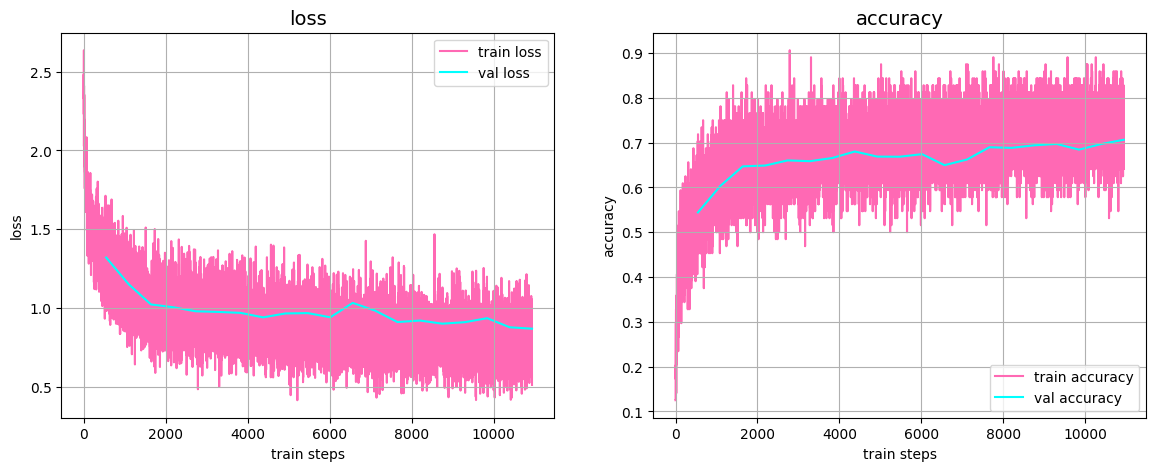

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Loss
axs[0].plot(train_loss_log, c="#FF69B4", label="train loss", zorder=1)
steps = list(
    range(0, len(train_loss_log) + 1, int(len(train_loss_log) / len(val_loss_log)))
)[1:]
axs[0].plot(steps, val_loss_log, c="#00FFFF", label="val loss", zorder=1)
axs[0].set_title("loss", fontsize=14)
axs[0].set_xlabel("train steps")
axs[0].set_ylabel("loss")
axs[0].legend()
axs[0].grid(True)

# Accuracy
axs[1].plot(train_acc_log, c="#FF69B4", label="train accuracy", zorder=1)
steps = list(
    range(0, len(train_acc_log) + 1, int(len(train_acc_log) / len(val_acc_log)))
)[1:]
axs[1].plot(steps, val_acc_log, c="#00FFFF", label="val accuracy", zorder=1)
axs[1].set_title("accuracy", fontsize=14)
axs[1].set_xlabel("train steps")
axs[1].set_ylabel("accuracy")
axs[1].legend()
axs[1].grid(True)
plt.show()